In [511]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [512]:
dataset_path = '../DATASET/INITIAL_DATASET'
train_path = os.path.join(dataset_path, 'train.csv')
test_path = os.path.join(dataset_path, 'test.csv')

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [513]:
train_df['source'] = 'train'
test_df['source'] = 'test'

full_df = pd.concat([train_df, test_df], ignore_index=True)

In [514]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [515]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [516]:
result = pd.concat([train_df.isna().sum(),train_df.isna().mean()],axis=1)
result

,0,1
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,0.198653
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [517]:
grouped = full_df.groupby(["Sex", "Pclass"])["Age"]

summary = grouped.agg(
    missing_percentage=lambda x: x.isna().mean() * 100,
    count="count"  # number of non-missing Age values
)

# To include total number of records (including NaN Age)
summary["total_records"] = grouped.size()

print(summary)

               missing_percentage  count  total_records
Sex    Pclass                                          
female 1                 7.638889    133            144
       2                 2.830189    103            106
       3                29.629630    152            216
male   1                15.642458    151            179
       2                 7.602339    158            171
       3                29.208925    349            493


In [518]:
full_df["Title"] = full_df["Name"].str.split(",").str[1].str.strip().str.split(" ").str[0]
pclass3 = full_df[full_df["Pclass"] == 3]

# Get all unique titles
unique_titles = pclass3["Title"].unique()

print("Unique titles in Pclass 3:")
print(unique_titles)
print(full_df["Title"].unique())

Unique titles in Pclass 3:
['Mr.' 'Miss.' 'Master.' 'Mrs.' 'Ms.']
['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.' 'Dona.']


In [519]:
# Group by Title
title_summary = full_df.groupby("Title")["Age"].agg(
    average_age=lambda x: x.mean(),                # mean age
    missing_percentage=lambda x: x.isna().mean() * 100, # % of missing ages
    count=lambda x: x.size
)

print(title_summary)

           average_age  missing_percentage  count
Title                                            
Capt.        70.000000            0.000000      1
Col.         54.000000            0.000000      4
Don.         40.000000            0.000000      1
Dona.        39.000000            0.000000      1
Dr.          43.571429           12.500000      8
Jonkheer.    38.000000            0.000000      1
Lady.        48.000000            0.000000      1
Major.       48.500000            0.000000      2
Master.       5.482642           13.114754     61
Miss.        21.774238           19.230769    260
Mlle.        24.000000            0.000000      2
Mme.         24.000000            0.000000      1
Mr.          32.252151           23.249670    757
Mrs.         36.994118           13.705584    197
Ms.          28.000000           50.000000      2
Rev.         41.250000            0.000000      8
Sir.         49.000000            0.000000      1
the          33.000000            0.000000      1


In [520]:
print(f'Age mean:{full_df["Age"].mean()}')
print(f'Age median:{full_df["Age"].median()}')

Age mean:29.881137667304014
Age median:28.0


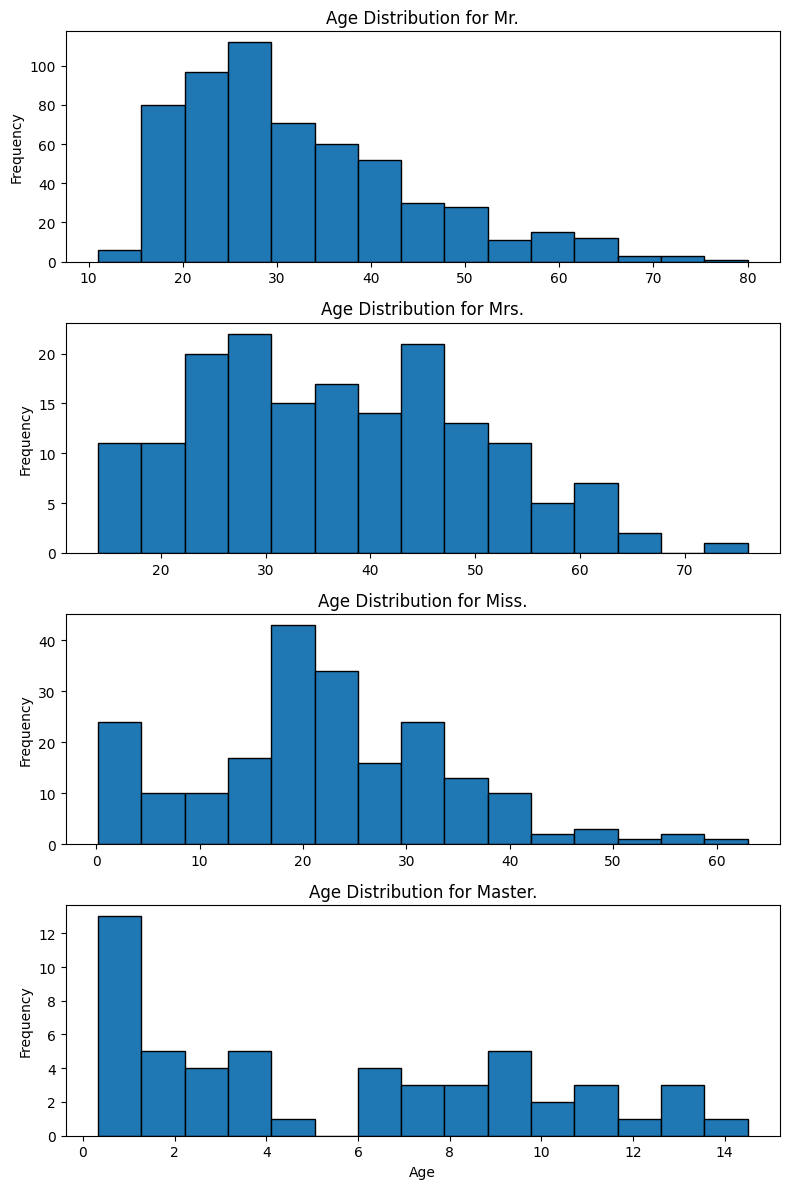

In [521]:
titles_to_plot = ["Mr.", "Mrs.", "Miss.", "Master."]

fig, axes = plt.subplots(len(titles_to_plot), 1, figsize=(8, 12), sharex=False)


for ax, title in zip(axes, titles_to_plot):
    age_data = full_df.loc[full_df["Title"] == title, "Age"].dropna()
    ax.hist(age_data, bins=15, edgecolor="black")
    ax.set_title(f"Age Distribution for {title}")
    ax.set_ylabel("Frequency")

plt.xlabel("Age")
plt.tight_layout()
plt.show()

In [522]:
max_age_master = full_df.loc[df['Title'] == 'Master.', 'Age'].dropna().max()
min_age_mr = full_df.loc[df['Title'] == 'Mr.', 'Age'].dropna().min()

print(f"The maximum age for title Master. is: {max_age_master}")
print(f"The minimum age for title Mr. is: {min_age_mr}")

mr_below_15 = full_df.loc[(full_df['Title'] == 'Mr.') & (full_df['Age'] < 15)]

print(f"The number of Mr. with age below 15 is: {mr_below_15}")

full_df.loc[(full_df['Title'] == 'Master.') & (full_df['Age'] == 14), 'Title'] = 'Mr.'

full_df.loc[(full_df['Title'] == 'Mr.') & (full_df['Age'] == 11), 'Title'] = 'Master.'


The maximum age for title Master. is: 14.5
The minimum age for title Mr. is: 14.0
The number of Mr. with age below 15 is:       PassengerId  Survived  Pclass                         Name   Sex   Age  \
683           684       0.0       3  Goodwin, Mr. Charles Edward  male  14.0   
686           687       0.0       3     Panula, Mr. Jaako Arnold  male  14.0   
731           732       0.0       3     Hassan, Mr. Houssein G N  male  11.0   
896           897       NaN       3   Svensson, Mr. Johan Cervin  male  14.0   
1121         1122       NaN       2  Sweet, Mr. George Frederick  male  14.0   

      SibSp  Parch   Ticket     Fare Cabin Embarked source Title  
683       5      2  CA 2144  46.9000   NaN        S  train   Mr.  
686       4      1  3101295  39.6875   NaN        S  train   Mr.  
731       0      0     2699  18.7875   NaN        C  train   Mr.  
896       0      0     7538   9.2250   NaN        S   test   Mr.  
1121      0      0   220845  65.0000   NaN        S   test   M

In [523]:
train_df = full_df[full_df["source"] == "train"]

# Group by Title and calculate summary
title_summary = train_df.groupby("Title").agg(
    total_passengers=("Survived", "count"),       # total number of passengers per title
    survival_percentage=("Survived", lambda x: x.mean() * 100)  # % survived
).sort_values(by="survival_percentage", ascending=False)

print(title_summary)

           total_passengers  survival_percentage
Title                                           
the                       1           100.000000
Mlle.                     2           100.000000
Sir.                      1           100.000000
Ms.                       1           100.000000
Lady.                     1           100.000000
Mme.                      1           100.000000
Mrs.                    125            79.200000
Miss.                   182            69.780220
Master.                  41            56.097561
Col.                      2            50.000000
Major.                    2            50.000000
Dr.                       7            42.857143
Mr.                     516            15.697674
Jonkheer.                 1             0.000000
Rev.                      6             0.000000
Don.                      1             0.000000
Capt.                     1             0.000000


In [524]:
def encode_title(title):
    if title in ["Mr."]:
        return "Mr"
    elif title in ["Mrs.", "Mme."]:
        return "Mrs"
    elif title in ["Miss.", "Mlle.", "Ms."]:
        return "Miss"
    elif title == "Master.":
        return "Master"
    else:
        return "Rare"

# Apply encoding
full_df["Title_Encoded"] = full_df["Title"].apply(encode_title)

# Check distribution
print(full_df["Title_Encoded"].value_counts())

Title_Encoded
Mr        756
Miss      264
Mrs       198
Master     62
Rare       29
Name: count, dtype: int64


In [525]:
# Filter for training dataset
train_df = full_df[full_df["source"] == "train"]

# Calculate survival percentage by Title
survival_by_title = train_df.groupby("Title_Encoded")["Survived"].agg(
    total_passengers="count",
    survival_percentage=lambda x: x.mean() * 100
)

print(survival_by_title)

               total_passengers  survival_percentage
Title_Encoded                                       
Master                       41            56.097561
Miss                        185            70.270270
Mr                          516            15.697674
Mrs                         126            79.365079
Rare                         23            34.782609


In [526]:
df = full_df.copy()
le = LabelEncoder()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform='pandas')

In [527]:
larger_dataset = "y"
df['Embarked'] = le.fit_transform(df['Embarked'])
df['Embarked'] = df['Embarked'].replace(3, np.nan)
ohetransform = ohe.fit_transform(df[['Sex']])
df = pd.concat([df, ohetransform], axis=1).drop(columns=['Sex'])
full_df = pd.concat([full_df, ohetransform], axis=1).drop(columns=['Sex'])
if larger_dataset == 'y':
    ohetransform = ohe.fit_transform(df[['Title_Encoded']])
    df = pd.concat([df, ohetransform], axis=1).drop(columns='Title_Encoded')
    full_df = pd.concat([full_df, ohetransform], axis=1).drop(columns="Title_Encoded")

In [528]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'source', 'Title', 'Sex_female',
       'Sex_male', 'Title_Encoded_Master', 'Title_Encoded_Miss',
       'Title_Encoded_Mr', 'Title_Encoded_Mrs', 'Title_Encoded_Rare'],
      dtype='object')

In [529]:
if larger_dataset == 'y':
    features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_male', 'Sex_female',
               'Title_Encoded_Master', 'Title_Encoded_Miss',
                'Title_Encoded_Mr', 'Title_Encoded_Mrs', 'Title_Encoded_Rare'] 
elif larger_dataset == 'n':
    features = ['Pclass', 'Age','SibSp', 'Parch', 'Sex_male', 'Sex_female']
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df[features]), columns=features)

In [530]:
full_df.loc[full_df["Fare"].isna()]
mean_fare_p3 = full_df.loc[full_df["Pclass"]==3, "Fare"].mean()
full_df['Fare'] = full_df["Fare"].fillna(mean_fare_p3)

In [366]:
max_fare_p3 = full_df.loc[full_df["Pclass"] == 3, "Fare"].max()

# Get the name(s) of the passenger(s) with this fare
names_max_fare_p3 = full_df.loc[(full_df["Pclass"] == 3) & (full_df["Fare"] == max_fare_p3), "Name"]

print(f"The maximum fare for Pclass 3 is: {max_fare_p3}")
print("Passenger(s) with this fare:")
print(names_max_fare_p3.tolist())

The maximum fare for Pclass 3 is: 69.55
Passenger(s) with this fare:
['Sage, Master. Thomas Henry', 'Sage, Miss. Constance Gladys', 'Sage, Mr. Frederick', 'Sage, Mr. George John Jr', 'Sage, Miss. Stella Anna', 'Sage, Mr. Douglas Bullen', 'Sage, Miss. Dorothy Edith "Dolly"', 'Sage, Miss. Ada', 'Sage, Mr. John George', 'Sage, Master. William Henry', 'Sage, Mrs. John (Annie Bullen)']


In [380]:
full_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'source', 'Title', 'Sex_female',
       'Sex_male', 'Title_Encoded_Master', 'Title_Encoded_Miss',
       'Title_Encoded_Mr', 'Title_Encoded_Mrs', 'Title_Encoded_Rare',
       'GroupSize', 'Fare_per_person'],
      dtype='object')

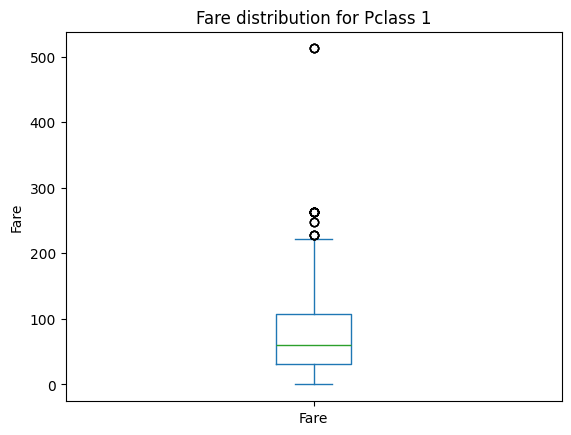

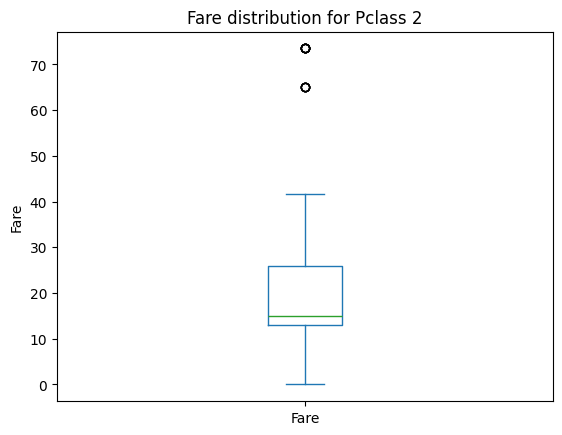

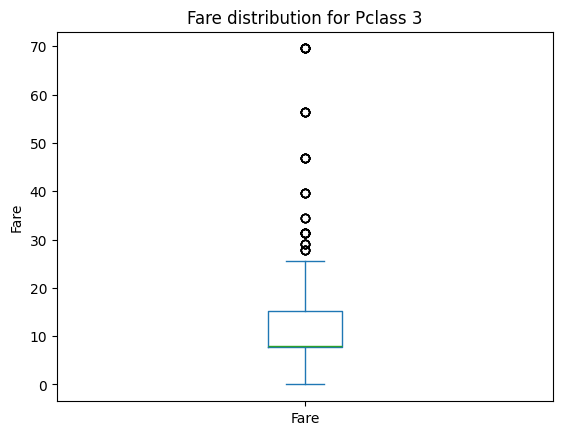

In [363]:
import matplotlib.pyplot as plt

for pclass in sorted(full_df["Pclass"].unique()):
    plt.figure()
    full_df.loc[full_df["Pclass"] == pclass, "Fare"].plot.box()
    plt.title(f"Fare distribution for Pclass {pclass}")
    plt.ylabel("Fare")
    plt.show()

In [377]:
# Count passengers per ticket
ticket_counts = full_df['Ticket'].value_counts()

# Map counts back to the dataframe
full_df['GroupSize'] = full_df['Ticket'].map(ticket_counts)

full_df["GroupSize"].value_counts()

GroupSize
1     713
2     264
3     147
4      64
5      35
7      35
6      24
8      16
11     11
Name: count, dtype: int64

In [531]:
full_df["Embarked"] = full_df["Embarked"].fillna("S")
ohetransform = ohe.fit_transform(full_df[['Embarked']])
full_df = pd.concat([full_df, ohetransform], axis=1).drop(columns='Embarked')


In [532]:
full_df['Age_missing'] = full_df['Age'].isna().astype(int)

In [533]:
full_df['Age'] = full_df['Age'].fillna(df_imputed['Age'])

In [568]:
train_df = full_df[full_df['source']=='train'].copy().drop(columns=['source', 'Name', 'Ticket', 'Cabin', 
                                                                    'Title'])
test_df = full_df[full_df['source']=='test'].copy().drop(columns=['source', 'Name', 'Ticket', 'Cabin', 
                                                                    'Title'])

In [571]:
features = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age_missing','Title_Encoded_Master', 
                                                                    'Title_Encoded_Miss',
                                                                    'Title_Encoded_Mr', 
                                                                    'Title_Encoded_Mrs', 
                                                                    'Title_Encoded_Rare']
X_train = train_df[features]
y_train = train_df['Survived']

X_test = test_df[features]

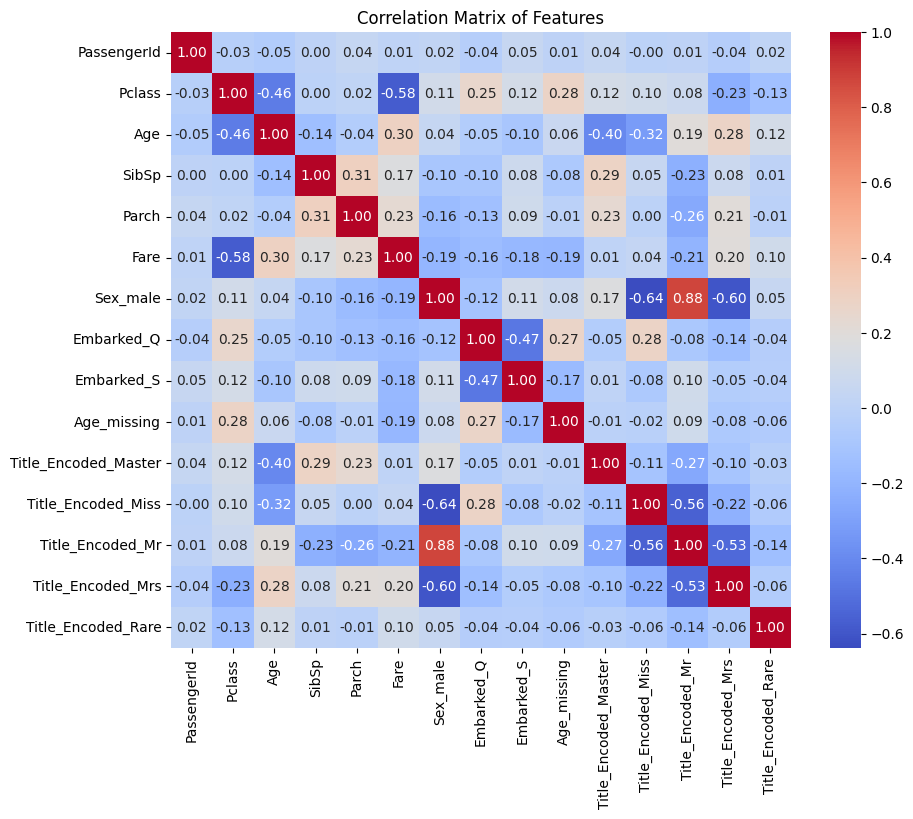

In [572]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Assuming your DataFrame is called df
plt.figure(figsize=(10, 8))

# Compute correlation matrix
corr_matrix = X_test.corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Features")
plt.show()


In [582]:
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer


search_space = {
    'max_depth': Integer(2, 10),
    'learning_rate': Real(0.001, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'colsample_bylevel': Real(0.5, 1.0),
    'colsample_bynode': Real(0.5, 1.0),
    'reg_alpha':Real(0, 10),
    'reg_lambda':Real(0, 10),
    'gamma':Real(0, 10)
    
}

xgb = XGBClassifier(n_estimators=500, objective='binary:logistic', random_state=42)


bayes_search = BayesSearchCV(estimator=xgb, search_spaces=search_space, n_iter=75, cv=9, n_jobs=-1, verbose=1)
bayes_search.fit(X_train, y_train)


print(f"Best parameters: {bayes_search.best_params_}")
print(f"Best score: {bayes_search.best_score_}")
# test_predictions = model.predict(X_test)
# submission = pd.DataFrame({
#     'PassengerId': test_df['PassengerId'],
#     'Survived': test_predictions
# })
# submission.to_csv('titanic_xgb_bayes_submission.csv', index=False)

Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fi

In [583]:
# Predict on the test set using the best found model
test_predictions = bayes_search.predict(X_test)

# Prepare the submission file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('titanic_xgb_bayes_submission_correct_age.csv', index=False)

In [567]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

# Base XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Bagging wrapper
bagging_model = BaggingClassifier(
    estimator=xgb_model,
    n_estimators=10,       # Number of XGB models (can also tune)
    max_samples=0.8,
    max_features=1.0,
    random_state=42
)

# Setup Bayesian search
bayes_search = BayesSearchCV(
    estimator=bagging_model,
    search_spaces=param_space,
    n_iter=30,            # Number of iterations
    cv=5,                 # Cross-validation folds
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Run search
bayes_search.fit(X_train, y_train)

# Best params
print("Best parameters:", bayes_search.best_params_)print(f"Best score: {bayes_search.best_score_}")
# Predict on the test set using the best found model
test_predictions = bayes_search.predict(X_test)

# Prepare the submission file
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('titanic_xgb_bayes_submission_correct_age.csv', index=False)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

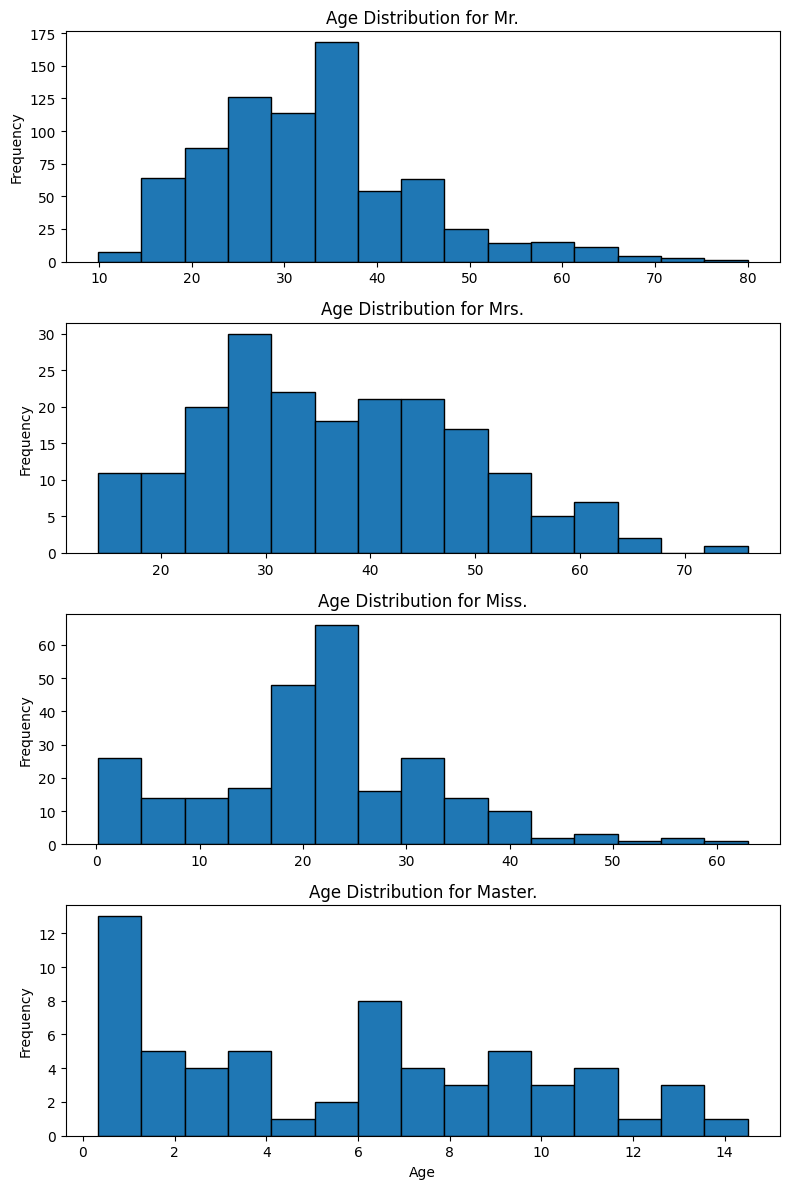

In [326]:
titles_to_plot = ["Mr.", "Mrs.", "Miss.", "Master."]

fig, axes = plt.subplots(len(titles_to_plot), 1, figsize=(8, 12), sharex=False)


for ax, title in zip(axes, titles_to_plot):
    age_data = full_df.loc[full_df["Title"] == title, "Age"]
    ax.hist(age_data, bins=15, edgecolor="black")
    ax.set_title(f"Age Distribution for {title}")
    ax.set_ylabel("Frequency")

plt.xlabel("Age")
plt.tight_layout()
plt.show()




In [461]:
X_train["Embarked_S"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
886   NaN
887   NaN
888   NaN
889   NaN
890   NaN
Name: Embarked_S, Length: 891, dtype: float64